In [1]:
import sys
sys.path.append('../')
from backtester import *

In [2]:
data = pd.read_csv('../forex_prices/m5/EUR_USD_m5.csv', index_col=['date'], parse_dates=['date'])
freq = 'm5'
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data.head())
print(data.shape)

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-21 12:35:00,1.17674,1.17632,1.17677,1.17626,1.17686,1.17645,1.17688,1.17638,878,1.176800,1.176825,1.176320,1.176385
2021-07-21 12:40:00,1.17632,1.17625,1.17646,1.17614,1.17645,1.17638,1.17658,1.17625,1104,1.176385,1.176520,1.176195,1.176315
2021-07-21 12:45:00,1.17625,1.17594,1.17625,1.17594,1.17638,1.17606,1.17638,1.17606,1328,1.176315,1.176315,1.176000,1.176000
2021-07-21 12:50:00,1.17594,1.17637,1.17672,1.17591,1.17606,1.17650,1.17685,1.17603,1301,1.176000,1.176785,1.175970,1.176435
2021-07-21 12:55:00,1.17637,1.17654,1.17663,1.17614,1.17650,1.17667,1.17675,1.17626,1311,1.176435,1.176690,1.176200,1.176605


(10000, 13)


In [3]:
# get MA
windows = (160, 190)
for i, window in enumerate(windows):
    data[f'MA_{i}'] = ta.momentum.kama(data['close'], window=window, fillna=False)
  
# get MACD
windows = (170, 200, 200)
data['macd_signal_line'] = ta.trend.macd_signal(data['close'], window_fast=50, window_slow=20, window_sign=130, fillna=False)


# get RSI
window = 16
data['rsi'] = ta.momentum.rsi(data['close'], window=window, fillna=False)


# get SO
windows = (35, 100)
so = ta.momentum.StochasticOscillator(high=data['high'], low=data['low'], close=data['close'],
                                      window=windows[0], smooth_window=windows[1], fillna=False)
data['%K'] = so.stoch()
data['%D'] = so.stoch_signal()

# get BB
windows = (180, 2)
bb = ta.volatility.BollingerBands(close=data['close'], window=windows[0], window_dev=windows[1], fillna=False)
data['bb_high'] = bb.bollinger_hband()
data['bb_avg'] = bb.bollinger_mavg()
data['bb_low'] = bb.bollinger_lband()


In [4]:
# get signals
data.dropna(axis=0, inplace=True)

# MA
data['ma_signal'] = np.where(data['MA_0'] > data['MA_1'], 1, 
                             np.where(data['MA_1'] > data['MA_0'], -1, 0))  

# MACD
data['macd_signal'] = np.where(data['macd_signal_line'] > 0, 1,
                               np.where(data['macd_signal_line'] < 0, -1, 0))

# RSI
data['rsi_signal'] = np.where(data['rsi'] > 70, -1,
                              np.where(data['rsi'] < 30, 1, np.nan))
data['rsi_signal'] = data['rsi_signal'].ffill().fillna(0)

# SO
data['so_signal'] = np.where(data['%D'] > 80, -1,
                             np.where(data['%D'] < 20, 1, np.nan))
data['so_signal'] = data['so_signal'].ffill().fillna(0)

# BB
data['bb_distance'] = data['close'] - data['bb_avg']
data['bb_signal'] = np.where(data['close'] < data['bb_low'], 1,
                     np.where(data['close'] > data['bb_high'], -1, 
                              np.where(data['bb_distance']*data['bb_distance'].shift(1)<0, 0, np.nan)))
data['bb_signal'] = data['bb_signal'].ffill().fillna(0)

In [5]:
signals = data[['ma_signal', 'macd_signal', 'rsi_signal', 'so_signal', 'bb_signal']].mode(axis=1)

In [6]:
signals # some periods have two mode

,0,1
date,,
2021-07-22 04:20:00,0.0,NaN
2021-07-22 04:25:00,0.0,NaN
2021-07-22 04:30:00,0.0,NaN
2021-07-22 04:35:00,0.0,NaN
2021-07-22 04:40:00,0.0,NaN
...,...,...
2021-09-08 03:40:00,-1.0,NaN
2021-09-08 03:45:00,-1.0,NaN
2021-09-08 03:50:00,-1.0,NaN


In [7]:
signals[0].value_counts()

-1.0    5687
 1.0    3953
 0.0     171
Name: 0, dtype: int64

In [8]:
signals[1].value_counts()

1.0    1394
0.0     173
Name: 1, dtype: int64

In [9]:
backtester = IterativeBacktester(data=data, freq=freq, signals=signals[0])

In [10]:
backtester.backtest()

  0%|          | 0/9810 [00:00<?, ?it/s]

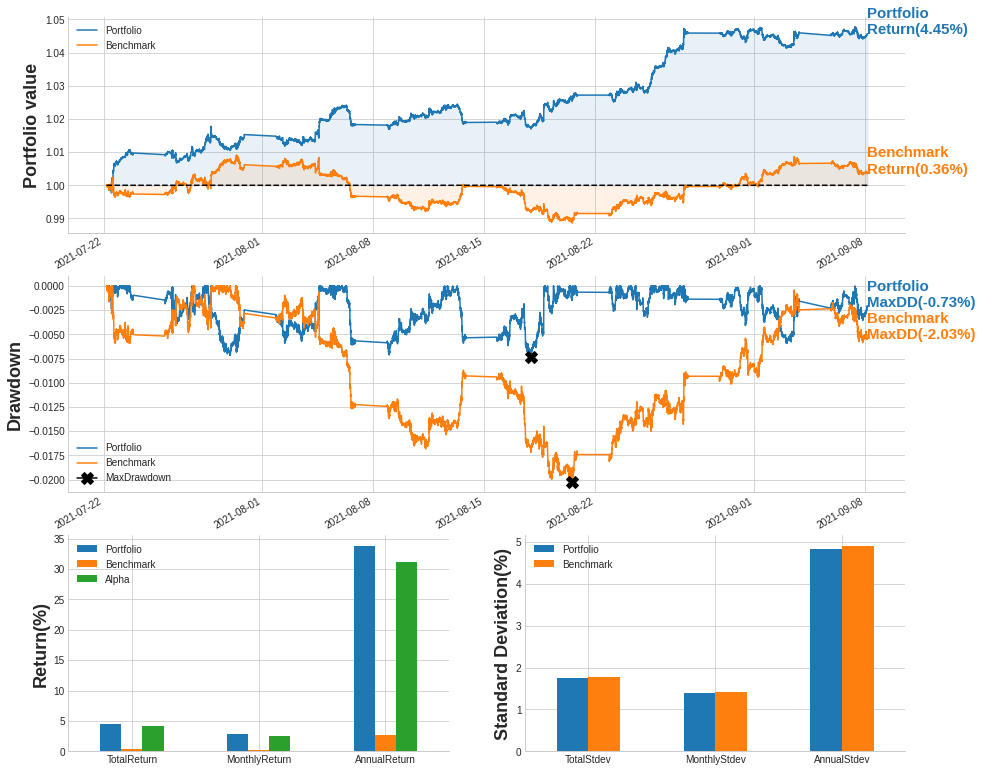

----------------------------------------------------------------------
Data length: |47 days 23:40:00|
Data range from |2021-07-22 04:20:00| to |2021-09-08 04:00:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │       4.454 │       0.357 │   4.097 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │       2.784 │       0.223 │   2.561 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      33.875 │       2.716 │  31.160 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │   

In [11]:
backtester.results()